In [1]:
# Import section
import pandas as pd
import numpy as np 
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNetCV, ElasticNet
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
import scipy

### Contenu

* [Exploration de données](#Exploration_de_données)
* [Premier Dataset](#Premier_Dataset)
    * [Data Processing](#Data_Processing)
    * [Tests de modèles 1 (aggrégation journalière)](#Tests_de_modèles_1(aggrégation_journalière))
* [Second Dataset](#Second_Dataset)
    * [Modification du dataset](#Modification_du_dataset)
    * [Test de modèles 2 (aggrégation par période de la journée)](#Test_de_modèles_2_(aggrégation_par_période_de_la_journée))
* [Troisème Dataset](#Troisème_Dataset)
    * [Modification du dataset](#Modification_du_dataset)
    * [Test modèles 3 (aggrégation jour, nuit)](#Test_modèles_3_(aggrégation_jour,_nuit)
* [Conclusion](#Conclusion)


### Exploration de données <a class="anchor" id="Exploration_de_données"></a>

In [2]:
# Import dataset

df = pd.read_csv("bike.csv", header=0)


df.head()


# Traduction des colonnes : 

# dteday	jour au format yyyy-mm-dd
# hr	heure
# weathersit	classe de la météo
# hum	humidité relative
# windspeed	vitesse du vent
# temp	température en °C
# atemp	température ressentie en °C
# cnt	décompte du nombre de vélos utilisés à cette heure

,dteday,hr,weathersit,hum,windspeed,temp,atemp,cnt
0,2011-01-01,0,clear,0.81,0.0,3.28,3.0014,16
1,2011-01-01,1,clear,0.80,0.0,2.34,1.9982,40
2,2011-01-01,2,clear,0.80,0.0,2.34,1.9982,32
3,2011-01-01,3,clear,0.75,0.0,3.28,3.0014,13
4,2011-01-01,4,clear,0.75,0.0,3.28,3.0014,1


In [3]:
# Vérifications des null

print(df.info())

print("Le data set n'a pas de null values")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   hr          17379 non-null  int64  
 2   weathersit  17379 non-null  object 
 3   hum         17379 non-null  float64
 4   windspeed   17379 non-null  float64
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   cnt         17379 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 1.1+ MB
None
Le data set n'a pas de null values


In [4]:
# Describe du dataset

print(df.describe())

print("L'humidité est déjà scale sur 0-1 ; le vent & la température ont des outliers forts ; \n le cnt varie énormément (probablement car on ne prend pas beaucoup de velib a 3h du matin) ; \n temp & atemp sont très proches, on gardera le ressenti car plus représentatif même si le min max a une grosse différence")

                 hr           hum     windspeed          temp         atemp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean      11.546752      0.627229     12.736540     15.358397     15.401157   
std        6.914405      0.192930      8.196795      9.050138     11.342114   
min        0.000000      0.000000      0.000000     -7.060000    -16.000000   
25%        6.000000      0.480000      7.001500      7.980000      5.997800   
50%       12.000000      0.630000     12.998000     15.500000     15.996800   
75%       18.000000      0.780000     16.997900     23.020000     24.999200   
max       23.000000      1.000000     56.996900     39.000000     50.000000   

                cnt  
count  17379.000000  
mean     189.463088  
std      181.387599  
min        1.000000  
25%       40.000000  
50%      142.000000  
75%      281.000000  
max      977.000000  
L'humidité est déjà scale sur 0-1 ; le vent & la température ont des outliers forts ; 
 le

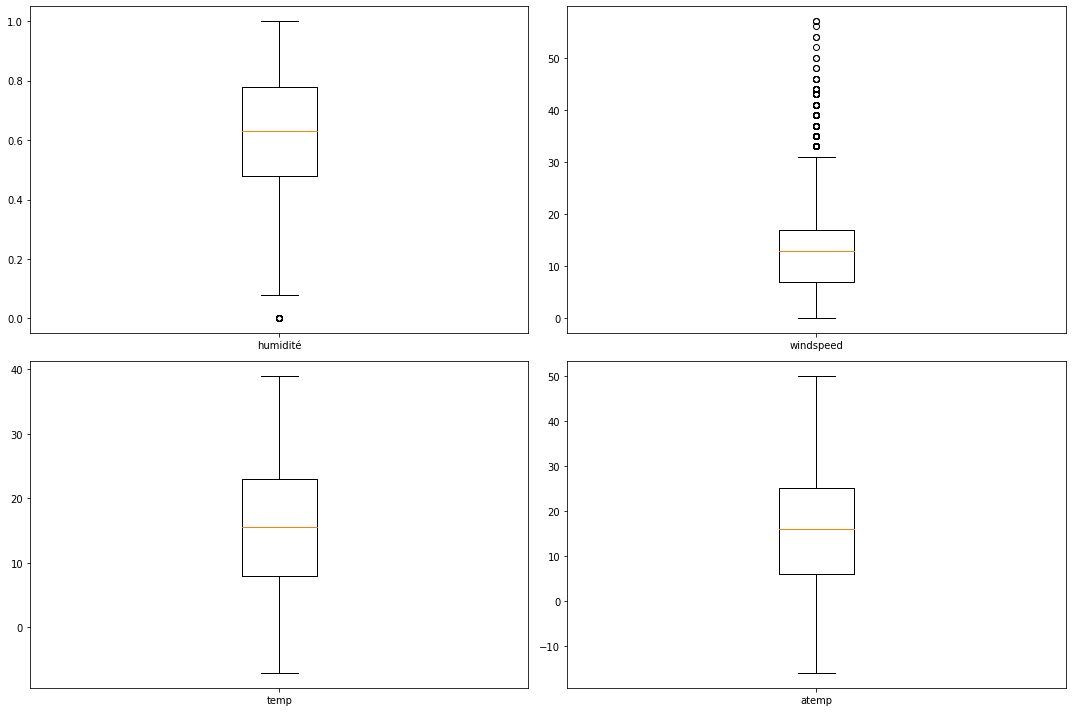

In [5]:
# Box plot des données pour visualiser le .describe()


fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(15)
axs[0,0].boxplot(df["hum"], labels=["humidité"])
axs[0,1].boxplot(df["windspeed"], labels=["windspeed"])
axs[1,0].boxplot(df["temp"], labels=["temp"])
axs[1,1].boxplot(df["atemp"], labels=["atemp"])
fig.tight_layout();


In [6]:
print("On peut confirmer que l'hmidité est bien répartie et sera certainement utile")
print("Le vent comporte beaucoup de fort outliers qui impactera la variable cible")
print("Temps et atemp sont effectivement très proches ce qui confirme le choix de n'en garder qu'un seul")

On peut confirmer que l'hmidité est bien répartie et sera certainement utile
Le vent comporte beaucoup de fort outliers qui impactera la variable cible
Temps et atemp sont effectivement très proches ce qui confirme le choix de n'en garder qu'un seul


L'utilisation des vélos (cible) est extrêmement tangeant avec beaucoup d'outliers, on devra donc garder un filet de sécurité 
 avec les prédictions de l'algorithme


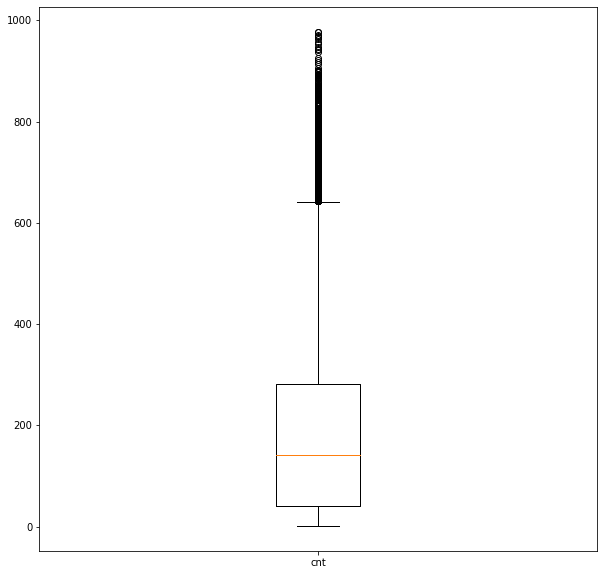

In [7]:
plt.figure(figsize=(10,10))
plt.boxplot(df["cnt"], labels=["cnt"])



print("L'utilisation des vélos (cible) est extrêmement tangeant avec beaucoup d'outliers, on devra donc garder un filet de sécurité \n avec les prédictions de l'algorithme")

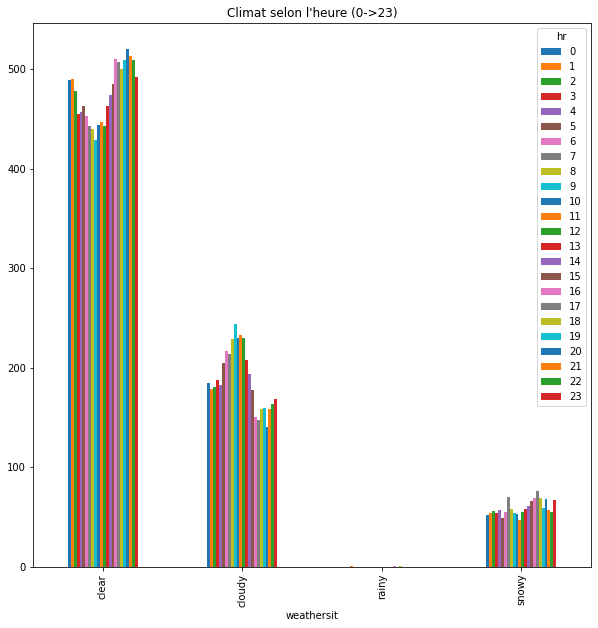

In [8]:
# Exploration répartition de weather


df.groupby(['weathersit', 'hr']).weathersit.count().unstack().plot.bar(figsize=(10,10), title="Climat selon l'heure (0->23)" )
plt.show();

In [9]:
print("On remarque une très faible probabilité de pluie, et une faible probabilité de neige (soit des météo peu propices au vélo), le temps est majoritairement clair")
print("Le temps nuagueux est plus présent en début de journée (5h ->14h) alors que le clair est plus présent en fin de journée et en nuit")

On remarque une très faible probabilité de pluie, et une faible probabilité de neige (soit des météo peu propices au vélo), le temps est majoritairement clair
Le temps nuagueux est plus présent en début de journée (5h ->14h) alors que le clair est plus présent en fin de journée et en nuit


In [10]:
#  Suppression de la colonne temp

df = df.drop("temp", axis=1)

### Premier Dataset <a class="anchor" id="Premier_Dataset"></a>

### Data Processing <a class="anchor" id="Data_Processing"></a>

In [11]:
# Creation d'un scaler
scaler = preprocessing.StandardScaler()

# Aggrégation à la journée (objectif : prédiction pour le lendemain)

work_df = df.copy()

# Ajout colonne journée

work_df["dteday"] = work_df["dteday"].astype("datetime64")
work_df["day_of_week"] = work_df["dteday"].dt.day_name()

# Moyenne sur les journée features quantitatives 

col_qlt = ["hr","weathersit"]
col_qty = ['hum', 'windspeed', 'atemp','cnt']

work_df_qty = work_df.drop(col_qlt, axis=1)

operations = {"hum":"mean", 
               "windspeed": "mean",
               "atemp": "mean",
               "cnt": "sum"}

work_df_qty = work_df_qty.groupby("dteday").agg(operations)


In [12]:
# Moyenne sur les journée features qualitatives


work_df_qlt = work_df.drop(col_qty, axis=1)
work_df_qlt = work_df_qlt.drop("hr", axis=1)
work_df_qlt = work_df_qlt.groupby(["dteday","day_of_week"]).agg(lambda x: scipy.stats.mode(x)[0]).reset_index()


In [13]:
# Test des aggrégations

print(work_df_qty.head())
print(work_df_qlt.head())

                 hum  windspeed     atemp   cnt
dteday                                         
2011-01-01  0.805833  10.749871  7.999250   985
2011-01-02  0.696087  16.652122  7.346783   801
2011-01-03  0.437273  16.636709 -3.499300  1349
2011-01-04  0.590435  10.739809 -1.999965  1562
2011-01-05  0.436957  12.522300 -0.868209  1600
      dteday day_of_week weathersit
0 2011-01-01    Saturday      clear
1 2011-01-02      Sunday     cloudy
2 2011-01-03      Monday      clear
3 2011-01-04     Tuesday      clear
4 2011-01-05   Wednesday      clear


In [14]:
# Séparation features et target

target = work_df_qty["cnt"]
work_df_qty = work_df_qty.drop("cnt", axis=1)

In [15]:
# Normalisation des variables quantitatives

work_df_qty_scaled = pd.DataFrame(scaler.fit_transform(work_df_qty), columns=work_df_qty.columns)

In [16]:
# Test de la normalisation

print(work_df_qty_scaled.head())

        hum  windspeed     atemp
0  1.250174  -0.387894 -0.679946
1  0.479113   0.749603 -0.740651
2 -1.339276   0.746633 -1.749770
3 -0.263183  -0.389833 -1.610272
4 -1.341498  -0.046307 -1.504973


In [17]:
# Jointure des features & dummy des features qualitatives

data = work_df_qty_scaled
data = data.join(pd.get_dummies(work_df_qlt["weathersit"]))
data = data.join(pd.get_dummies(work_df_qlt["day_of_week"]))
data = data.set_index(work_df_qty.index)

In [18]:
# Test de "data" et "target" df

print(data.head())
print(target.head())

                 hum  windspeed     atemp  clear  cloudy  snowy  Friday  \
dteday                                                                    
2011-01-01  1.250174  -0.387894 -0.679946      1       0      0       0   
2011-01-02  0.479113   0.749603 -0.740651      0       1      0       0   
2011-01-03 -1.339276   0.746633 -1.749770      1       0      0       0   
2011-01-04 -0.263183  -0.389833 -1.610272      1       0      0       0   
2011-01-05 -1.341498  -0.046307 -1.504973      1       0      0       0   

            Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  
dteday                                                              
2011-01-01       0         1       0         0        0          0  
2011-01-02       0         0       1         0        0          0  
2011-01-03       1         0       0         0        0          0  
2011-01-04       0         0       0         0        1          0  
2011-01-05       0         0       0         0        0     

### Tests de modèles 1 (aggrégation journalière) <a class="anchor" id="Tests_de_modèles_1(aggrégation_journalière)"></a>

Nous avons séparé la donnée en deux df (data & target)
Data est le df des features normalisées
Target est la cible à prédire
Tout d'abord nous testeron des modèles simples de Régression linéaire (LR)
Ensuite nous utiliserons un algorithme "neat picker" comme Lasso pour voir si des améliorations sont nottables
Nos statistiques de comparaisons seront principalement les valeurs score_ (le plus le meilleur) & mse_ (le moins le meilleur).

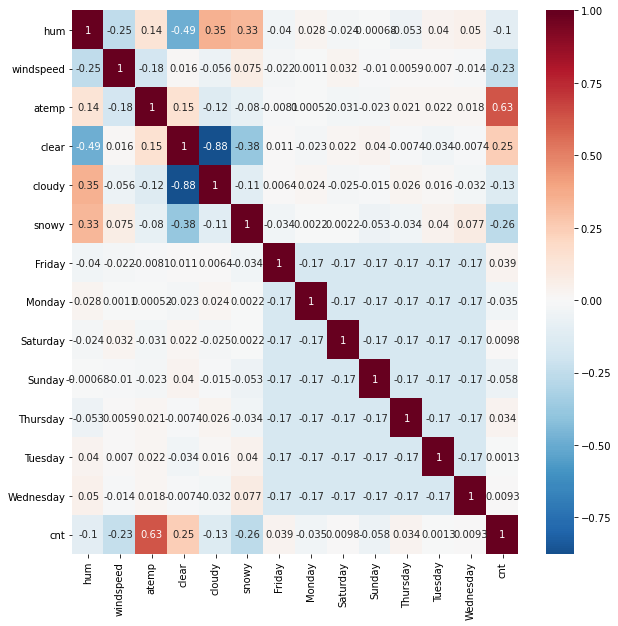

In [19]:
# Heatmap de corrélation pour sélectionner une feature de LR simple

corr_df = data.join(target)

plt.figure(figsize=(10,10))
sns.heatmap(corr_df.corr(), cmap="RdBu_r", center=0, annot=True);

# atemp semble la variable la plus corrélée avec cnt et nous utiliserons celle ci

In [20]:
# Split en train & test du dataset

X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(data,target, test_size=0.2, random_state=123)

In [21]:
# Modèle de LR simple

lr = LinearRegression()

lr.fit(X_train[["atemp"]], y_train)

LinearRegression()

In [22]:
score_lr_train = lr.score(X_train[["atemp"]],y_train)
score_lr_test = lr.score(X_test[["atemp"]],y_test)

pred_lr_train = lr.predict(X_train[["atemp"]])
pred_lr_test = lr.predict(X_test[["atemp"]])

print("score", score_lr_train, "rmse", np.sqrt(mean_squared_error(pred_lr_train, y_train)))
print("score", score_lr_test, "rmse", np.sqrt(mean_squared_error(pred_lr_test, y_test)))

print("le score de précision est très bas si on utilise uniquement atemp. De plus on remarque un fort overfitting")
print("L'overfitting se note car le score de train dépasse largement le score de test")

score 0.43338257011526105 rmse 1473.3547200747075
score 0.23437843580430417 rmse 1616.3573096890984
le score de précision est très bas si on utilise uniquement atemp. De plus on remarque un fort overfitting
L'overfitting se note car le score de train dépasse largement le score de test


In [23]:
# Creation d'un LR complex


lr_mul = LinearRegression()

lr_mul.fit(X_train, y_train)

LinearRegression()

In [24]:
score_lr_mul_train = lr_mul.score(X_train,y_train)
score_lr_mul_test = lr_mul.score(X_test,y_test)

pred_lr_mul_train = lr_mul.predict(X_train)
pred_lr_mul_test = lr_mul.predict(X_test)


print("score", score_lr_mul_train, "rmse", np.sqrt(mean_squared_error(pred_lr_mul_train, y_train)))
print("score", score_lr_mul_test, "rmse", np.sqrt(mean_squared_error(pred_lr_mul_test, y_test)))



print("On remarque un léger mieux mais l'overfitting est toujours là et le tx de précision est faible")

score 0.528604929449135 rmse 1343.8626142366688
score 0.2841410267228821 rmse 1562.946202560786
On remarque un léger mieux mais l'overfitting est toujours là et le tx de précision est faible


In [25]:
# Sur la heatmap il semble que seul windspeed, atemp, clear, cloudy, snowy aient un vrai impact
# Nous allons utiliser cette liste choisie à la main 

lr_mul_cherry = LinearRegression()
lr_mul_cherry.fit(X_train[["windspeed", "atemp", "clear", "cloudy", "snowy"]], y_train)

pred_lr_mul_cherry_train = lr_mul_cherry.predict(X_train[["windspeed", "atemp", "clear", "cloudy", "snowy"]])
pred_lr_mul_cherry_test = lr_mul_cherry.predict(X_test[["windspeed", "atemp", "clear", "cloudy", "snowy"]])

score_lr_mul_cherry_train = lr_mul_cherry.score(X_train[["windspeed", "atemp", "clear", "cloudy", "snowy"]],y_train)
score_lr_mul_cherry_test = lr_mul_cherry.score(X_test[["windspeed", "atemp", "clear", "cloudy", "snowy"]],y_test)


print("score", score_lr_mul_cherry_train, "rmse", np.sqrt(mean_squared_error(pred_lr_mul_cherry_train, y_train)))
print("score", score_lr_mul_cherry_test, "rmse", np.sqrt(mean_squared_error(pred_lr_mul_cherry_test, y_test)))
print("Le cherry pick manuel ne semble pas avoir un effet positif")

score 0.5032726963364259 rmse 1379.4989368387448
score 0.27769715110068904 rmse 1569.9649506671865
Le cherry pick manuel ne semble pas avoir un effet positif


In [26]:
# Essais via Elastic Net 

l1_ratio = (0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99)
alphas = (0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0)
cv = 5
max_iter = 10000

en = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, cv=cv, max_iter=max_iter)

en.fit(X_train, y_train)

ElasticNetCV(alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
             cv=5, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99),
             max_iter=10000)

In [27]:
# Observation des coeff des features

coef = list(en.coef_)
coef.insert(0, en.intercept_)
features = list(data.columns)
features.insert(0, "intercept")


print("les features ont presque toute un gros impact sur le nb de vélos ce qui peut expliquer les hésiations du modèle")
pd.DataFrame({"valeur": coef}, index=features)

les features ont presque toute un gros impact sur le nb de vélos ce qui peut expliquer les hésiations du modèle


,valeur
intercept,4195.760192
hum,-322.064961
windspeed,-343.831990
atemp,1229.702271
clear,404.192838
cloudy,263.152371
snowy,-768.138098
Friday,199.419366
Monday,-199.060946
Saturday,167.553228


In [28]:
# Prédiction et score de Elastic Net


pred_train_en = en.predict(X_train)
pred_test_en = en.predict(X_test)

print("score ", en.score(X_train, y_train), "rmse", np.sqrt(mean_squared_error(y_train, pred_train_en)))
print("score ", en.score(X_test, y_test), "rmse", np.sqrt(mean_squared_error(y_test, pred_test_en)))

score  0.5280632570786806 rmse 1344.6344978426828
score  0.2867475364108677 rmse 1560.0981908427873


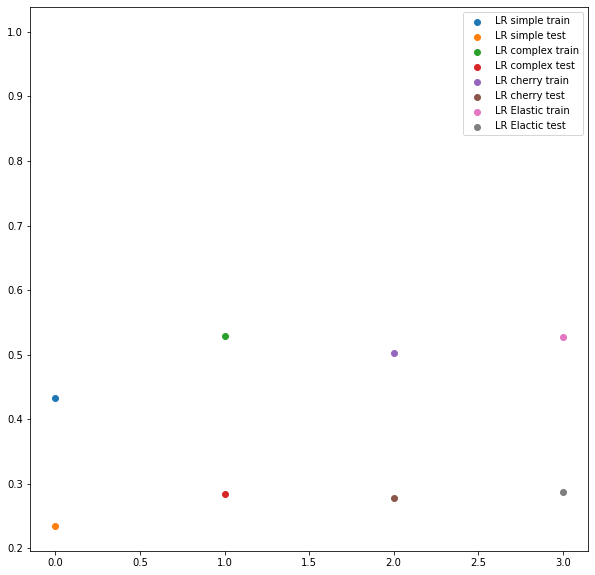

In [29]:
# Pour se rendre compte de l'évolution entre les méthodes visuellement 

plt.figure(figsize=(10,10))
plt.scatter(0,score_lr_train, label="LR simple train")
plt.scatter(0,score_lr_test, label="LR simple test")
plt.scatter(1,score_lr_mul_train, label="LR complex train")
plt.scatter(1,score_lr_mul_test, label="LR complex test")
plt.scatter(2,score_lr_mul_cherry_train, label="LR cherry train")
plt.scatter(2,score_lr_mul_cherry_test, label="LR cherry test")
plt.scatter(3,en.score(X_train, y_train), label="LR Elastic train")
plt.scatter(3,en.score(X_test, y_test), label="LR Elactic test")
plt.plot(0,1)
plt.legend();

on remarque une grande disparité entre le réel et le prédit


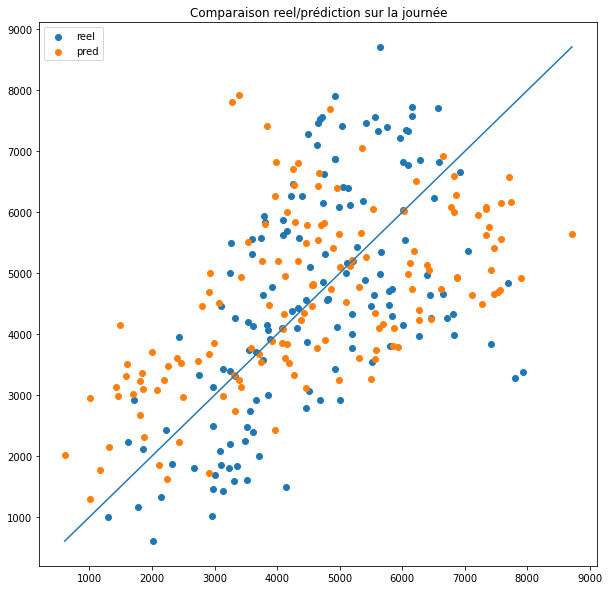

In [30]:
# Notre meilleur estimateur pour le moment est ElasticNet, on peut observer les résultats visuellement

plt.figure(figsize=(10,10))
plt.scatter(pred_test_en, y_test, label="reel")
plt.scatter( y_test, pred_test_en, label="pred")
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()))
plt.legend()
plt.title("Comparaison reel/prédiction sur la journée");

print("on remarque une grande disparité entre le réel et le prédit")

In [31]:
# On peut également analyser les résultats en tableau 

pd.DataFrame({"reel":y_test, "pred":np.round(pred_test_en)}, index=X_test.index)

,reel,pred
dteday,,
2012-05-03,6421,5046.0
2012-02-26,3389,3245.0
2011-04-02,2252,3481.0
2011-10-28,3747,3547.0
2011-06-27,4708,5787.0
...,...,...
2012-09-23,7907,4928.0
2012-07-02,6227,6508.0
2012-03-15,6192,5368.0


In [32]:
# Les prédictions sont beaucoup trop aléatoire. 
# Hypothéses d'amélioration : séparation en période de journée (matin, après midi, soir, nuit)

### Second Dataset <a class="anchor" id="Second_Dataset"></a>

### Modification du dataset <a class="anchor" id="Modification_du_dataset"></a>

In [33]:
# Nous allons modifier les paramètres en tenant compte des périodes de la journée. Cela permettra également de prendre en compte
# les variations dans la météo
# En ce qui concerne le data processing beacoup d'éléments seront des redites du travail déjà effectué avec quelques changements
# Pour gagner du temps de lecture on peut passer directement au chapitre V

In [34]:
# Data processing

# Scaler
scaler = preprocessing.StandardScaler()

# Aggrégation par jour

work_df2 = df.copy()

# Ajout "jour de la semaine"

work_df2["dteday"] = work_df["dteday"].astype("datetime64")
work_df2["day_of_week"] = work_df["dteday"].dt.day_name()

# Ajout période de la journée

period = []

night = [0,1,2,3,4,5,6]
morning= [7, 8, 9, 10, 11, 12]
afternoon = [13, 14, 15, 16, 17, 18]
evening = [19, 20, 21, 22, 23]

for i in df["hr"]:
    if  i in night:
        period.append("night")
    if  i in morning:
        period.append("morning")
    if  i in afternoon:
        period.append("afternoon")
    if  i in evening:
        period.append("evening")
        
work_df2["period"] = period

# Moyenne des données quantitatives sur la journée
col_qlt = ["hr","weathersit"]
col_qty = ['hum', 'windspeed', 'atemp','cnt']

work_df2_qty = work_df2.drop("weathersit", axis=1)

operations = {"hum":"mean", 
               "windspeed": "mean",
               "atemp": "mean",
               "cnt": "sum"}

work_df2_qty = work_df2_qty.groupby(["dteday","period"]).agg(operations)

In [35]:
# Moyenne des données qualitatives


work_df2_qlt = work_df2.drop(col_qty, axis=1)
work_df2_qlt = work_df2_qlt.drop("hr", axis=1)
work_df2_qlt = work_df2_qlt.groupby(["dteday","day_of_week","period"]).agg(lambda x: scipy.stats.mode(x)[0]).reset_index()

In [36]:
# Séparation des features et target

target2 = work_df2_qty["cnt"]
work_df2_qty = work_df2_qty.drop("cnt", axis=1)

In [37]:
# Normalisation & jointures

work_df2_qty_scaled = pd.DataFrame(scaler.fit_transform(work_df2_qty), columns=work_df2_qty.columns)

data2 = work_df2_qty_scaled
data2 = data2.join(pd.get_dummies(work_df2_qlt["weathersit"]))
data2 = data2.join(pd.get_dummies(work_df2_qlt["day_of_week"]))
data2 = data2.join(pd.get_dummies(work_df2_qlt["period"]))
data2 = data2.set_index(work_df2_qty.index)


In [38]:
# Test 

data2.head()

hum  windspeed     atemp  clear  cloudy  snowy  \
dteday     period                                                           
2011-01-01 afternoon  0.910409   0.923513 -0.217772      0       1      0   
           evening    1.461198   0.520532 -0.324506      0       1      0   
           morning    0.891988  -0.532546 -0.796291      1       0      0   
           night      0.864356  -1.742432 -1.171386      1       0      0   
2011-01-02 afternoon  0.210409   0.049878 -0.811175      0       0      1   

                      Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
dteday     period                                                           
2011-01-01 afternoon       0       0         1       0         0        0   
           evening         0       0         1       0         0        0   
           morning         0       0         1       0         0        0   
           night           0       0         1       0         0        0   
2011-01-02 afternoon       0       0         0       1         0        0   

                      Wednesday  afternoon  evening  morning  night  
dteday     period                                                    
2011-01-01 afternoon          0          1        0        0      0  
           evening            0          0        1        0      0  
           morning            0          0        0        1      0  
           night              0          0        0        0      1  
2011-01-02 afternoon          0          1        0        0      0

### Test de modèles 2 (aggrégation par période de la journée) <a class="anchor" id="Test_de_modèles_2_(aggrégation_par_période_de_la_journée)"></a>

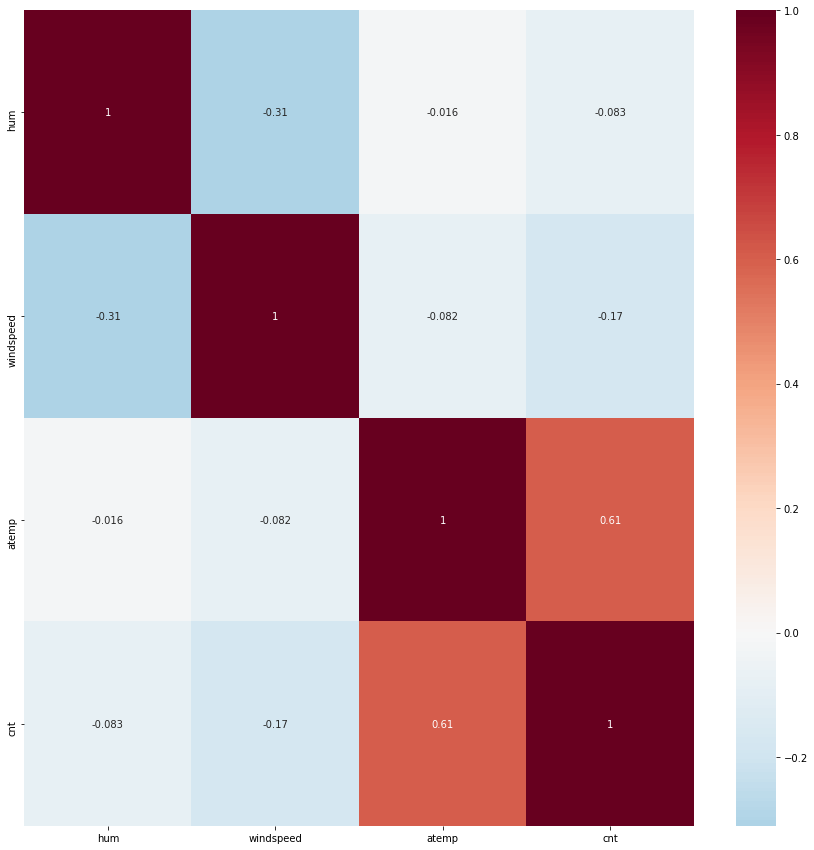

In [39]:
# Correlation heatmap

corr_df2 = data2.join(target)._get_numeric_data()

plt.figure(figsize=(15,15))
sns.heatmap(corr_df2[["hum","windspeed","atemp","cnt"]].corr(), cmap="RdBu_r", center=0, annot=True);

# Les corrélations sont différentes de la précédente heatmap on peut attendre de meilleurs résultats
# Les jours de la semaine ont un très faible corrélation et rendent la lecture difficile ils sont donc retirés de la heatmap

In [40]:
# Séparation du dataset

X_train2, X_test2, y_train2, y_test2 = skl.model_selection.train_test_split(data2,target2, test_size=0.2, random_state=123)

In [41]:
# On ignore la régression simple qui ménera au même résultat 

# Régression multiple 2


lr_mul2 = LinearRegression()

lr_mul2.fit(X_train2, y_train2)

score_lr_mul_train2 = lr_mul2.score(X_train2,y_train2)
score_lr_mul_test2 = lr_mul2.score(X_test2,y_test2)

pred_lr_mul_train2 = lr_mul2.predict(X_train2)
pred_lr_mul_test2 = lr_mul2.predict(X_test2)


print("score", score_lr_mul_train2, "rmse", np.sqrt(mean_squared_error(pred_lr_mul_train2, y_train2)))
print("score", score_lr_mul_test2, "rmse", np.sqrt(mean_squared_error(pred_lr_mul_test2, y_test2)))



print(f"On remarque une grande amélioration entre notre score initial {round(score_lr_mul_test,2)} et le score ici de ~ {round(score_lr_mul_test2,2)}"  )

score 0.7176699864398668 rmse 458.4618399232021
score 0.7129034650137676 rmse 452.4234917896402
On remarque une grande amélioration entre notre score initial 0.28 et le score ici de ~ 0.71


In [42]:
# Utilisation d'Elastic Net


l1_ratio = np.arange(0.001, 1, 0.1)
alphas = np.arange(0.001, 100, 0.1)
cv = 8
max_iter = 10000

en2 = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, cv=cv, max_iter=max_iter)

en2.fit(X_train2, y_train2)

ElasticNetCV(alphas=array([1.0000e-03, 1.0100e-01, 2.0100e-01, 3.0100e-01, 4.0100e-01,
       5.0100e-01, 6.0100e-01, 7.0100e-01, 8.0100e-01, 9.0100e-01,
       1.0010e+00, 1.1010e+00, 1.2010e+00, 1.3010e+00, 1.4010e+00,
       1.5010e+00, 1.6010e+00, 1.7010e+00, 1.8010e+00, 1.9010e+00,
       2.0010e+00, 2.1010e+00, 2.2010e+00, 2.3010e+00, 2.4010e+00,
       2.5010e+00, 2.6010e+00, 2.7010e+00, 2.8010e+00, 2.90...
       9.7501e+01, 9.7601e+01, 9.7701e+01, 9.7801e+01, 9.7901e+01,
       9.8001e+01, 9.8101e+01, 9.8201e+01, 9.8301e+01, 9.8401e+01,
       9.8501e+01, 9.8601e+01, 9.8701e+01, 9.8801e+01, 9.8901e+01,
       9.9001e+01, 9.9101e+01, 9.9201e+01, 9.9301e+01, 9.9401e+01,
       9.9501e+01, 9.9601e+01, 9.9701e+01, 9.9801e+01, 9.9901e+01]),
             cv=8,
             l1_ratio=array([0.001, 0.101, 0.201, 0.301, 0.401, 0.501, 0.601, 0.701, 0.801,
       0.901]),
             max_iter=10000)

les périodes que nous avons rajoutés ont un énorme impact sur la target (beaucoup plus que les jours)


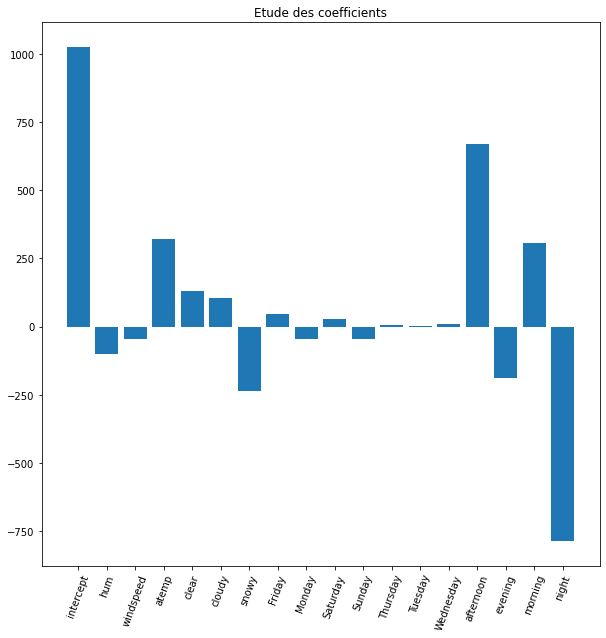

In [43]:
# Observation des features du nouveau dataset (via un barplot cette fois-ci)

coef2 = list(en2.coef_)
coef2.insert(0, en2.intercept_)
features2 = list(data2.columns)
features2.insert(0, "intercept")

x_pos = [i for i, _ in enumerate(features2)]

plt.figure(figsize=(10,10))
plt.bar([x for x in range(len(coef2))], coef2)
plt.xticks(x_pos, features2)
plt.xticks(rotation=70)
plt.title("Etude des coefficients");

print("les périodes que nous avons rajoutés ont un énorme impact sur la target (beaucoup plus que les jours)")


In [44]:
# Preds & scores


pred_train_en2 = en2.predict(X_train2)
pred_test_en2 = en2.predict(X_test2)

print("score ", en2.score(X_train2, y_train2), "rmse", np.sqrt(mean_squared_error(y_train2, pred_train_en2)))
print("score ", en2.score(X_test2, y_test2), "rmse", np.sqrt(mean_squared_error(y_test2, pred_test_en2)))

score  0.7176597036205896 rmse 458.47018872973115
score  0.7129689075585368 rmse 452.37192475827123


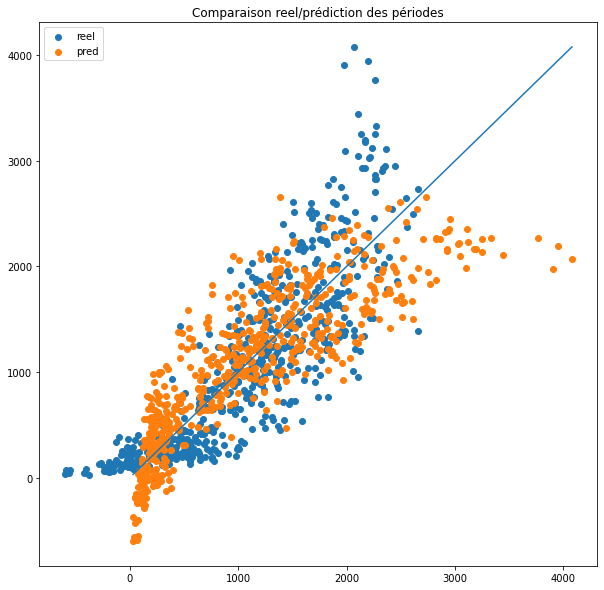

In [45]:
# Résultats visuels 

plt.figure(figsize=(10,10))
plt.scatter(pred_test_en2, y_test2, label="reel")
plt.scatter( y_test2, pred_test_en2, label="pred")
plt.plot((y_test2.min(), y_test2.max()), (y_test2.min(), y_test2.max()))
plt.title("Comparaison reel/prédiction des périodes")
plt.legend();

In [46]:
# Résultats en tableau 

res = pd.DataFrame({"reel":y_test2, "pred":np.round(pred_test_en2)}, index=X_test2.index)

print(res.head(20))

                      reel    pred
dteday     period                 
2012-04-18 night       242   493.0
2011-01-04 night        50  -187.0
2011-06-11 evening    1080  1215.0
2011-03-17 night       112    58.0
2011-12-20 evening     674   850.0
2012-06-14 morning    2254  1684.0
2012-02-27 evening     896   963.0
2012-12-22 evening     253   548.0
2012-10-12 evening    1251   934.0
2012-08-20 evening    1068  1006.0
2011-07-14 evening    1309  1324.0
2012-05-19 night       430   480.0
2011-01-26 night        41  -563.0
2012-10-07 night       376   258.0
2012-01-22 morning     555   677.0
2012-05-07 evening    1402  1024.0
2012-04-13 afternoon  2930  2142.0
2011-08-19 evening     558  1051.0
2011-04-19 night       136   335.0
2012-03-01 morning    1705  1455.0


In [47]:
# Les prédictions sont beaucoup plus précises
# Hypothéses d'amélioration on remarque que les nuits sont mal prédites tandis que les autres périodes sont globalement 
# bien prédite. Il y a un équilibrage à faire 


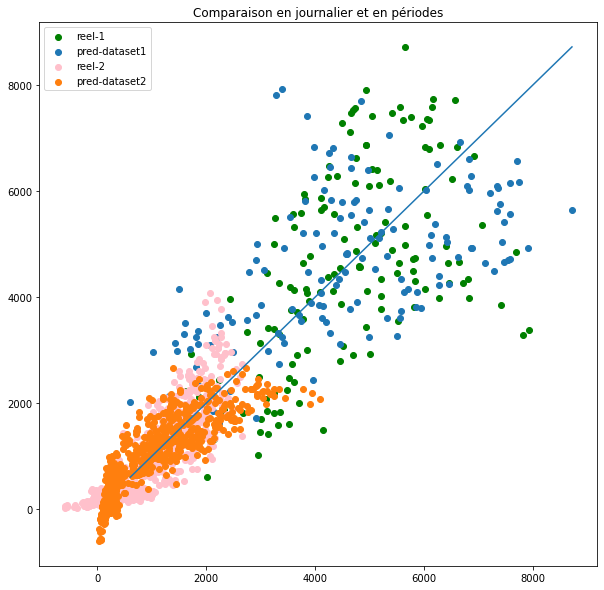

In [48]:
# Pour comparer l'amélioration nous pouvons superposer les deux graphiques 

plt.figure(figsize=(10,10))
plt.scatter(pred_test_en, y_test, label="reel-1", color='green')
plt.scatter( y_test, pred_test_en, label="pred-dataset1")
plt.scatter(pred_test_en2, y_test2, label="reel-2", color='pink')
plt.scatter( y_test2, pred_test_en2, label="pred-dataset2")
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()))
plt.title("Comparaison en journalier et en périodes")
plt.legend();

### Troisème Dataset <a class="anchor" id="Troisème_Dataset"></a>

### Modification du dataset <a class="anchor" id="Modification_du_dataset"></a>

In [49]:
# Data processing

# Scaler
scaler = preprocessing.StandardScaler()

# Aggrégation par jour

work_df3 = df.copy()

# Ajout "jour de la semaine"

work_df3["dteday"] = work_df3["dteday"].astype("datetime64")
work_df3["day_of_week"] = work_df3["dteday"].dt.day_name()

# Ajout période de la journée

period = []

night = [0,1,2,3,4,5,6]
day = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,  22, 23]


for i in df["hr"]:
    if  i in night:
        period.append("night")
    if  i in day:
        period.append("day")

        
work_df3["period"] = period

# Moyenne des données quantitatives sur la journée
col_qlt = ["hr","weathersit"]
col_qty = ['hum', 'windspeed', 'atemp','cnt']

work_df3_qty = work_df3.drop("weathersit", axis=1)

operations = {"hum":"mean", 
               "windspeed": "mean",
               "atemp": "mean",
               "cnt": "sum"}

work_df3_qty = work_df3_qty.groupby(["dteday","period"]).agg(operations)

In [50]:
# Moyenne des données qualitatives


work_df3_qlt = work_df3.drop(col_qty, axis=1)
work_df3_qlt = work_df3_qlt.drop("hr", axis=1)
work_df3_qlt = work_df3_qlt.groupby(["dteday","day_of_week","period"]).agg(lambda x: scipy.stats.mode(x)[0]).reset_index()

In [51]:
# Séparation de target en périodes

work_df4_qty = work_df3_qty.reset_index()
work_df4_qty = work_df4_qty.set_index("dteday")

mask_day_t = work_df4_qty["period"] == "day"
mask_night_t = work_df4_qty["period"] == "night"

target_day = work_df4_qty[mask_day_t]
target_night = work_df4_qty[mask_night_t]

target_day = target_day["cnt"]
target_night = target_night["cnt"]


In [52]:
# Normalisation & jointures

work_df3_qty = work_df3_qty.drop("cnt", axis=1)
work_df3_qty_scaled = pd.DataFrame(scaler.fit_transform(work_df3_qty), columns=work_df3_qty.columns)

data3 = work_df3_qty_scaled
data3 = data3.join(pd.get_dummies(work_df3_qlt["weathersit"]))
data3 = data3.join(pd.get_dummies(work_df3_qlt["day_of_week"]))
data3 = data3.join(pd.get_dummies(work_df3_qlt["period"]))
data3 = data3.set_index(work_df3_qty.index)


In [53]:
# Retrait des périodes car non pertinent pour les modèles

mask_day = data3["day"] == 1
mask_night = data3["night"] == 1

data_day = data3[mask_day]
data_night = data3[mask_night]


### Test modèles 3 (aggrégation jour, nuit) <a class="anchor" id="Test_modèles_3_(aggrégation_jour,_nuit)"></a>

In [54]:
# Afin de ne pas rallonger l'étude plus que nécessaire nous passerons directements aux modèles LR & Elastic net

# pour rappel 
# Nuit = 00h --> 6h
# day = 7h --> 23h
# Un meilleur nom aurait pu être "heures pleines" "heures creuses" 

In [55]:
# Séparation du dataset jour

X_train3, X_test3, y_train3, y_test3 = skl.model_selection.train_test_split(data_day,target_day, test_size=0.2, random_state=123)

# Séparation du dataset nuit

X_train4, X_test4, y_train4, y_test4 = skl.model_selection.train_test_split(data_night,target_night, test_size=0.2, random_state=123)

In [56]:
# On ignore la régression simple qui ménera au même résultat 

# Régression multiple jour


lr_mul3 = LinearRegression()

lr_mul3.fit(X_train3, y_train3)

score_lr_mul_train3 = lr_mul3.score(X_train3,y_train3)
score_lr_mul_test3 = lr_mul3.score(X_test3,y_test3)

pred_lr_mul_train3 = lr_mul3.predict(X_train3)
pred_lr_mul_test3 = lr_mul3.predict(X_test3)


print("score", score_lr_mul_train3, "rmse", np.sqrt(mean_squared_error(pred_lr_mul_train3, y_train3)))
print("score", score_lr_mul_test3, "rmse", np.sqrt(mean_squared_error(pred_lr_mul_test3, y_test3)))
print("Les données pour la plage horaire 'jour' donnent de très mauvais résultats")

score 0.5412791012977809 rmse 1265.9670629629306
score 0.27216716642003425 rmse 1486.9524852869301
Les données pour la plage horaire 'jour' donnent de très mauvais résultats


In [57]:
# On ignore la régression simple qui ménera au même résultat 

# Régression multiple nuit


lr_mul4 = LinearRegression()

lr_mul4.fit(X_train4, y_train4)

score_lr_mul_train4 = lr_mul4.score(X_train4,y_train4)
score_lr_mul_test4 = lr_mul4.score(X_test4,y_test4)

pred_lr_mul_train4 = lr_mul4.predict(X_train4)
pred_lr_mul_test4 = lr_mul4.predict(X_test4)


print("score", score_lr_mul_train4, "rmse", np.sqrt(mean_squared_error(pred_lr_mul_train4, y_train4)))
print("score", score_lr_mul_test4, "rmse", np.sqrt(mean_squared_error(pred_lr_mul_test4, y_test4)))
print("Les données pour la plage horaire 'nuit' semblent donner de meilleurs résultats")

score 0.5455796196065066 rmse 74.45529278635924
score 0.5991374550713513 rmse 69.84753562704516
Les données pour la plage horaire 'nuit' semblent donner de meilleurs résultats


In [58]:
# Utilisation d'Elastic Net Jour


l1_ratio = np.arange(0.001, 1, 0.1)
alphas = np.arange(0.001, 100, 0.1)
cv = 8
max_iter = 10000

en3 = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, cv=cv, max_iter=max_iter)

en3.fit(X_train3, y_train3)

pred_train_en3 = en3.predict(X_train3)
pred_test_en3 = en3.predict(X_test3)

print("score ", en3.score(X_train3, y_train3), "rmse", np.sqrt(mean_squared_error(y_train3, pred_train_en3)))
print("score ", en3.score(X_test3, y_test3), "rmse", np.sqrt(mean_squared_error(y_test3, pred_test_en3)))
print("Même constat que pour la LR")

score  0.5407349966622986 rmse 1266.7176439943166
score  0.27891819230304804 rmse 1480.0402928144022
Même constat que pour la LR


In [59]:
# Utilisation d'Elastic Net nuit


l1_ratio = np.arange(0.001, 1, 0.1)
alphas = np.arange(0.001, 100, 0.1)
cv = 8
max_iter = 10000

en4 = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, cv=cv, max_iter=max_iter)

en4.fit(X_train4, y_train4)

pred_train_en4 = en4.predict(X_train4)
pred_test_en4 = en4.predict(X_test4)

print("score ", en4.score(X_train4, y_train4), "rmse", np.sqrt(mean_squared_error(y_train4, pred_train_en4)))
print("score ", en4.score(X_test4, y_test4), "rmse", np.sqrt(mean_squared_error(y_test4, pred_test_en4)))
print("Le score Elastic net est très légèrement inférieur au score LR, cela doit venir du jeu de données plus restreint")

score  0.5455694695408606 rmse 74.45612430924211
score  0.5987757641711933 rmse 69.879039595537
Le score Elastic net est très légèrement inférieur au score LR, cela doit venir du jeu de données plus restreint


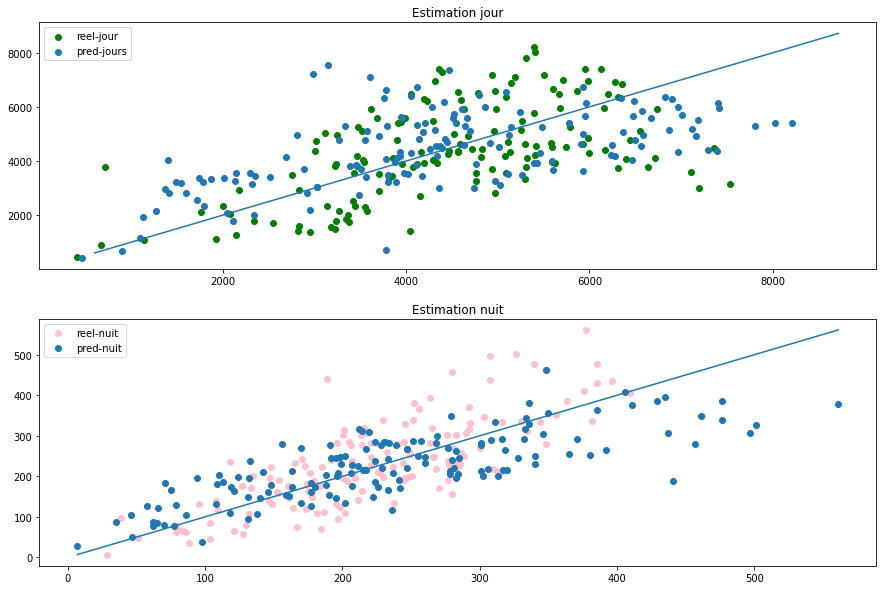

In [60]:
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].scatter(pred_lr_mul_test3, y_test3, label="reel-jour", color='green')
axs[0].scatter( y_test3, pred_lr_mul_test3, label="pred-jours")
axs[0].plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()))
axs[0].legend()
axs[0].title.set_text("Estimation jour")
axs[1].scatter(pred_lr_mul_test4, y_test4, label="reel-nuit", color='pink')
axs[1].scatter( y_test4, pred_lr_mul_test4, label="pred-nuit")
axs[1].plot((y_test4.min(), y_test4.max()), (y_test4.min(), y_test4.max()))
axs[1].title.set_text("Estimation nuit")
plt.legend();

In [61]:
print("On remarque que la période 0h --> 6h est globalement bien prédite comparativement à la précédente, ce que l'on confirme \n à la cellule suivante")

On remarque que la période 0h --> 6h est globalement bien prédite comparativement à la précédente, ce que l'on confirme 
 à la cellule suivante


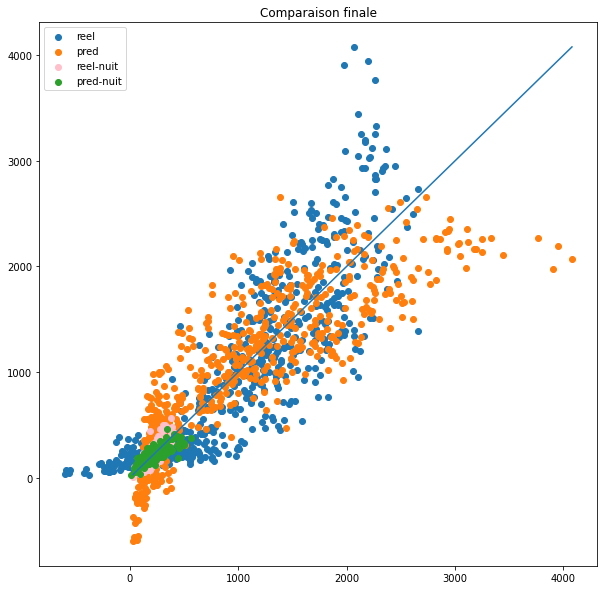

In [62]:
plt.figure(figsize=(10,10))
plt.scatter(pred_test_en2, y_test2, label="reel")
plt.scatter( y_test2, pred_test_en2, label="pred")
plt.plot((y_test2.min(), y_test2.max()), (y_test2.min(), y_test2.max()))
plt.scatter(pred_lr_mul_test4, y_test4, label="reel-nuit", color='pink')
plt.scatter( y_test4, pred_lr_mul_test4, label="pred-nuit")
plt.title("Comparaison finale")
plt.legend();

In [63]:
print("On voit très clairement un équilibrage sur la nuit, nous déveloperons cela dans la conclusion")

On voit très clairement un équilibrage sur la nuit, nous déveloperons cela dans la conclusion


### Conclusion <a class="anchor" id="Conclusion"></a>

   Dans cette étude sur l'utilisation des vélos d'une ville on remarque que le sujet est complexe car de nombreux facteurs vont entrer en ligne de compte : la météo, le jour de le semaine, l'heure, l'événement de la journée (1er de l'an, concert, ...), ... Egalement il y a le facteur humain à prendre en compte qui détient un aléatoire non négligeable. 

   Lors de l'étude nous avons pu conclure que pour les données de la journée on obtient une précision satisfaisante même si un léger "buffer" est à garder à l'esprit. L'utilisation peut varier de 100 à 200 vélos de manière imprévue (facteur humain). 
   
   Certaines heures sont cependant des wildcards qui peuvent largement influencer les choix de l'algorithme. Par exemple prendre le vélo un vendredi tard le soir est commun mais le prendre un mardi tard le soir est très peu commun. Ces données biaises l'algorithme et mène à un RMSE importante. 
   
   L'approche à la journée complète donne des résultats faibles (~20% de précision), découper la journée en segments donne un avantage certain sur les résultats qui montent jusqu'à ~72% de précision.
   Cependant cette précision est mauvaise pour certaines tranches horraires, nottament la nuit. Pour compenser cela on peut garder les résultats par période pour prévoir l'intégralité de la journée puis réevaluer individuellement la nuit (0->6h) pour réequilibrer les résultats. 
   
   D'autres améliorations sont également possibles via un dataset plus important qui permettrait d'utiliser des KFold ou du shuffle sans pour autant impacter négativement les résultats.